In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clipped_stats

In [2]:
lc1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc')
lc2 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc')
lc3 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.lc')
lc4 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.lc')

In [3]:
lc1_data = lc1[1].data
lc2_data = lc2[1].data
lc3_data = lc3[1].data
lc4_data = lc4[1].data

In [4]:
clean_lc = [lc1_data, lc2_data, lc3_data, lc4_data]

In [5]:
lc_rates = [clean_lc[i].field('RATE') for i in range(0,4)]
lc_times = [clean_lc[i].field('TIME') for i in range(0,4)]

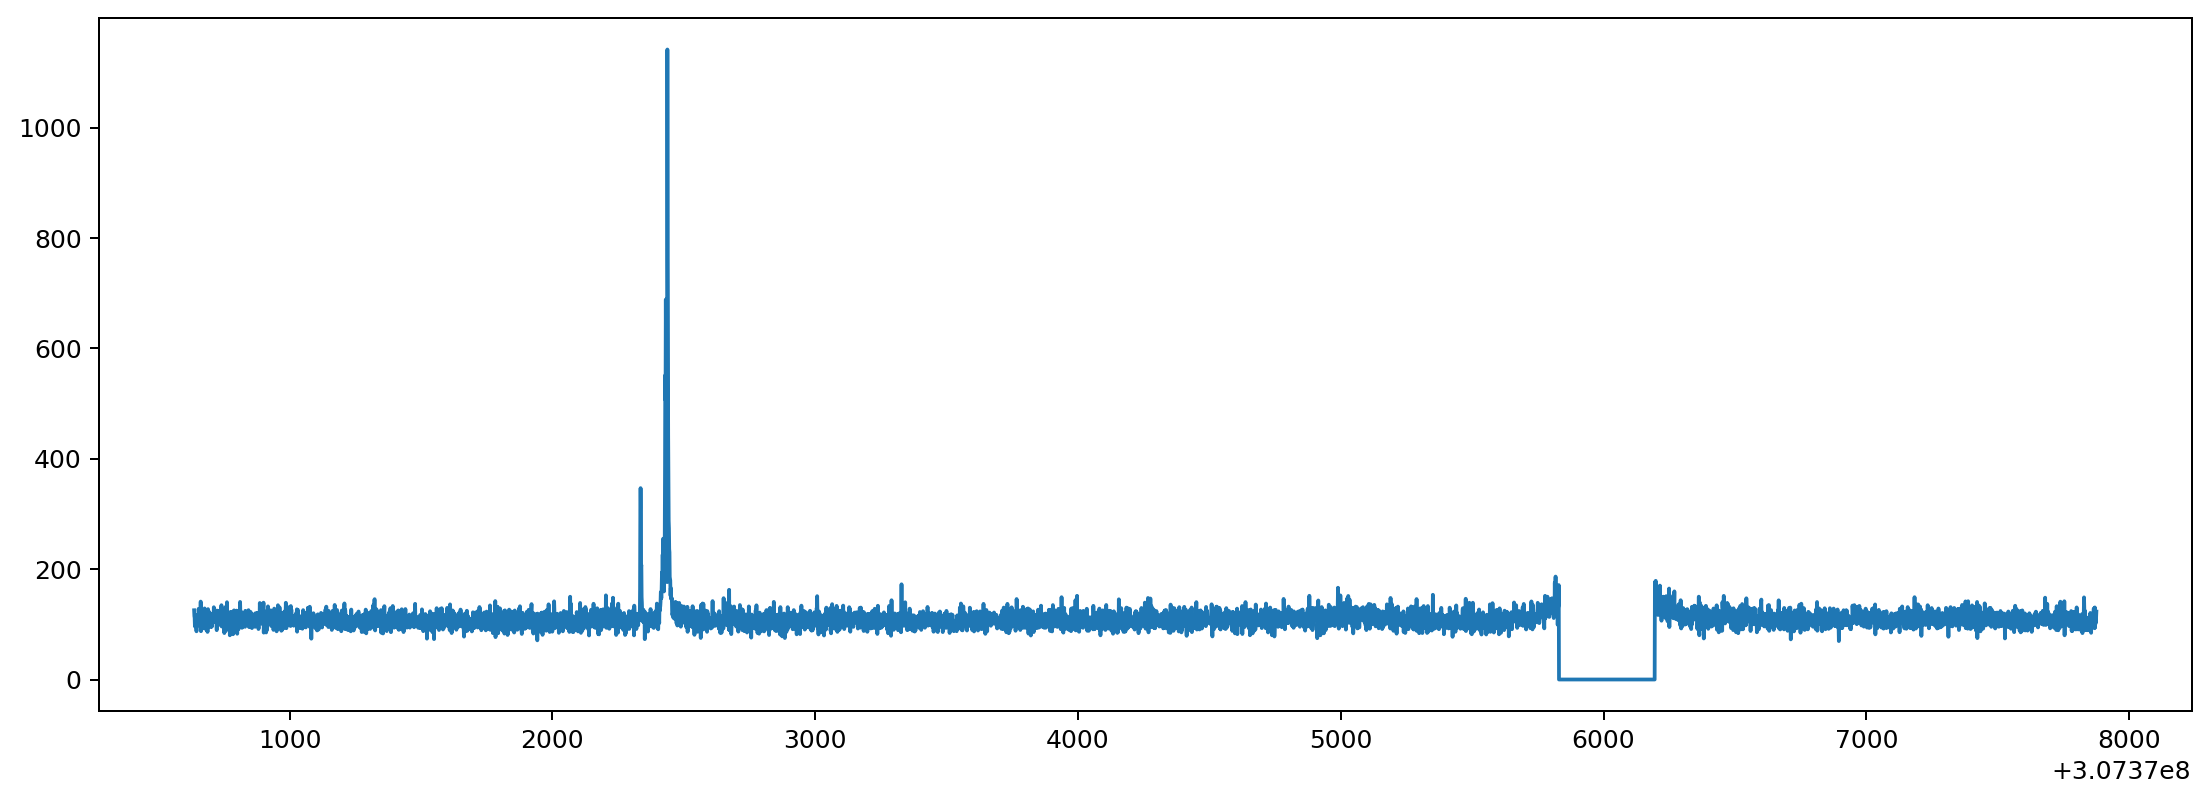

In [6]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc_times[0], lc_rates[0])
plt.show()

In [7]:
lc_medians = [np.median(lc_rates[i]) for i in range(0,4)]
lc_stds = [np.std(lc_rates[i]) for i in range(0,4)]

In [8]:
saa_indices = np.array([np.where(lc_rates[i] == 0) for i in range(0,4)])

In [9]:
saa_start_ind = saa_indices[0][0][0]
saa_end_ind = saa_indices[0][0][-1]

In [10]:
saa_start_ind

5194

In [11]:
mean, median, stddev = sigma_clipped_stats(lc_rates[0])

In [12]:
lc_rates_detrend = np.array(lc_rates)
lc_rates_detrend[0][:5194] = lc_rates[0][:5194] - median
lc_rates_detrend[0][5559:] = lc_rates[0][5559:] - median

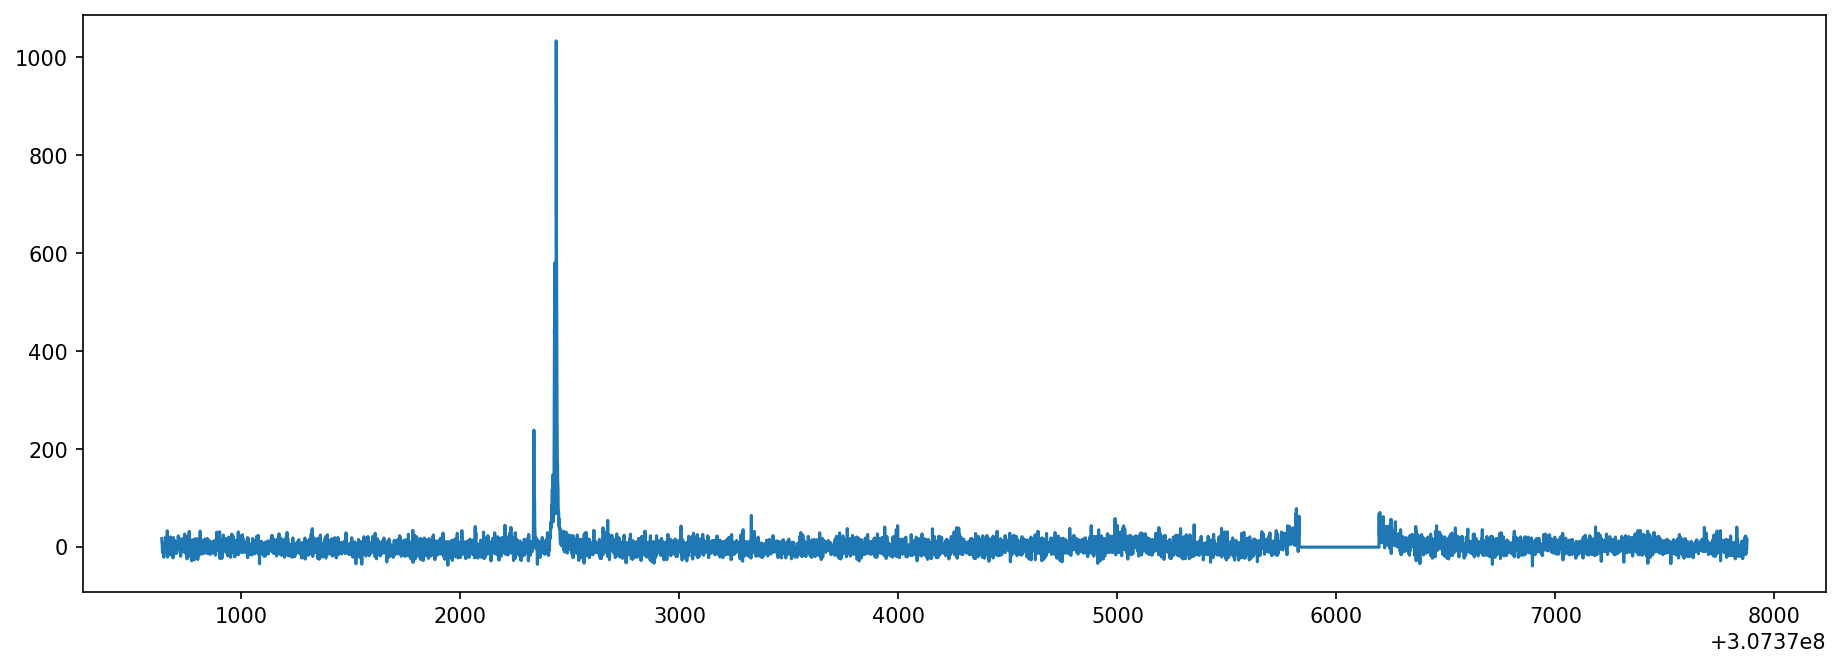

In [13]:
plt.figure(dpi=150, figsize=(15,5))
plt.plot(lc_times[0], lc_rates_detrend[0])
plt.show()

In [14]:
def median_filter(data, bins):
    smooth_data = np.array(data)
    med = []
    for i in range(0, data.size, bins):
        med.append(np.median(data[i:i+1]))
    med = np.array(med)
    ind = np.arange(0,data.size,bins)
    for i in range(0,med.size-1):
        smooth_data[ind[i]:ind[i+1]] = med[i]*np.ones_like(smooth_data[ind[i]:ind[i+1]])
    return smooth_data

In [15]:
np.median(lc_rates_detrend[0][100:200])

2.400631

In [16]:
smooth = median_filter(lc_rates[0], 10)

In [17]:
np.size(smooth)

7240

In [18]:
from scipy import signal

In [19]:
max_ind = np.where(lc_rates_detrend[0] == np.max(lc_rates_detrend[0]))

In [20]:
max = max_ind[0][0]

In [21]:
lc_times[0][max-20]

307372417.5

In [22]:
lc_times[0][max+20]

307372457.5

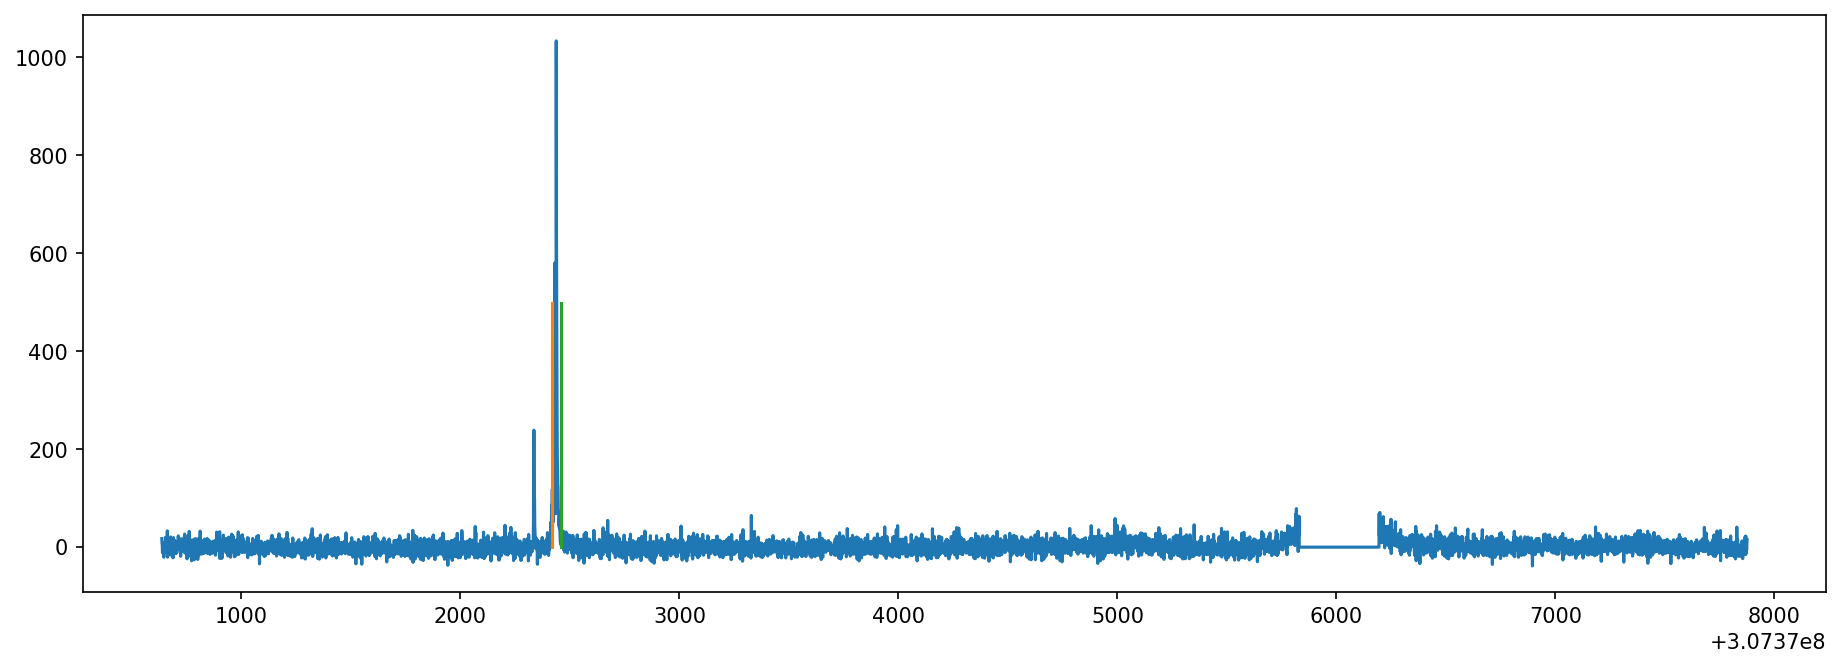

In [23]:
plt.figure(dpi=150, figsize=(15,5))
plt.plot(lc_times[0], lc_rates_detrend[0])
plt.plot(lc_times[0][max-20]*np.ones(500), np.arange(0,500))
plt.plot(lc_times[0][max+20]*np.ones(500), np.arange(0,500))
plt.show()

In [24]:
lc_med_filt = signal.medfilt(lc_rates[0],101)

In [25]:
lc_filt = signal.savgol_filter(lc_rates[0], 101,2)

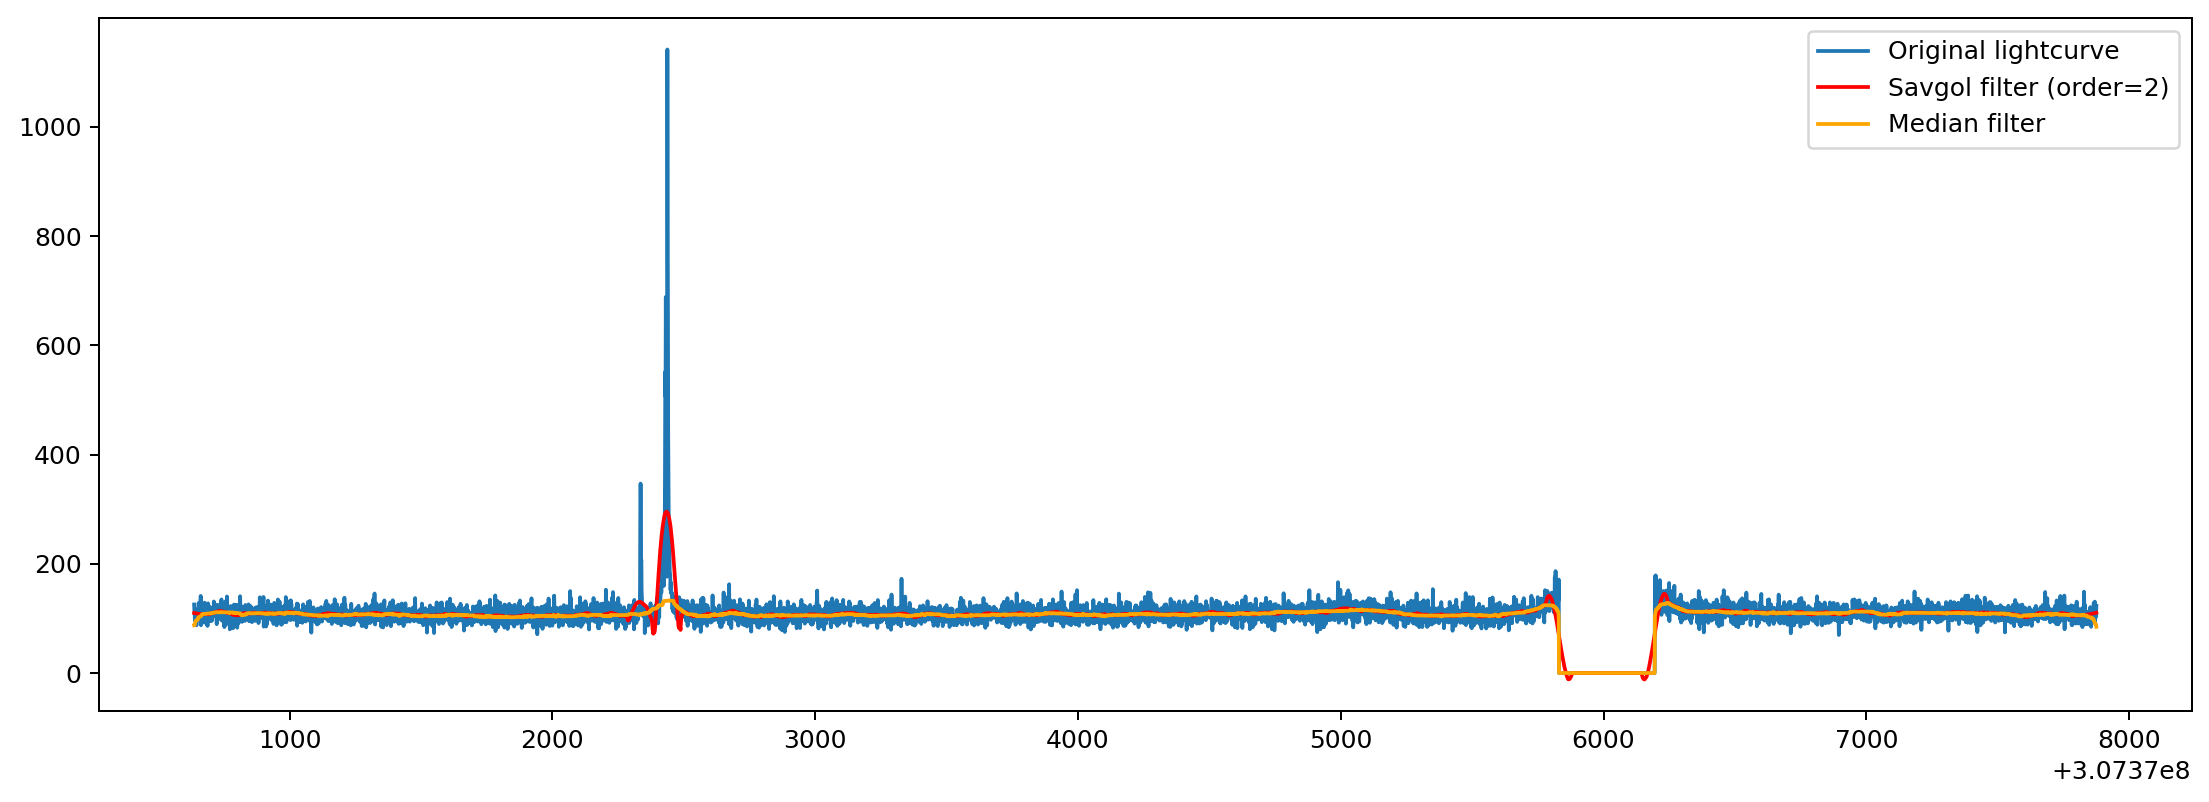

In [26]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc_times[0], lc_rates[0])
plt.plot(lc_times[0], lc_filt, 'r')
plt.plot(lc_times[0], lc_med_filt, 'orange')
plt.legend(['Original lightcurve', 'Savgol filter (order=2)', 'Median filter'])
plt.show()

In [27]:
lc_detrend = np.zeros_like(lc_rates[0])
lc_detrend[:saa_start_ind] = lc_rates[0][:saa_start_ind] - lc_filt[:saa_start_ind]
lc_detrend[saa_end_ind:] = lc_rates[0][saa_end_ind:] - lc_filt[saa_end_ind:]

lc_med_detrend = np.zeros_like(lc_rates[0])
lc_med_detrend[:saa_start_ind] = lc_rates[0][:saa_start_ind] - lc_med_filt[:saa_start_ind]
lc_med_detrend[saa_end_ind:] = lc_rates[0][saa_end_ind:] - lc_med_filt[saa_end_ind:]

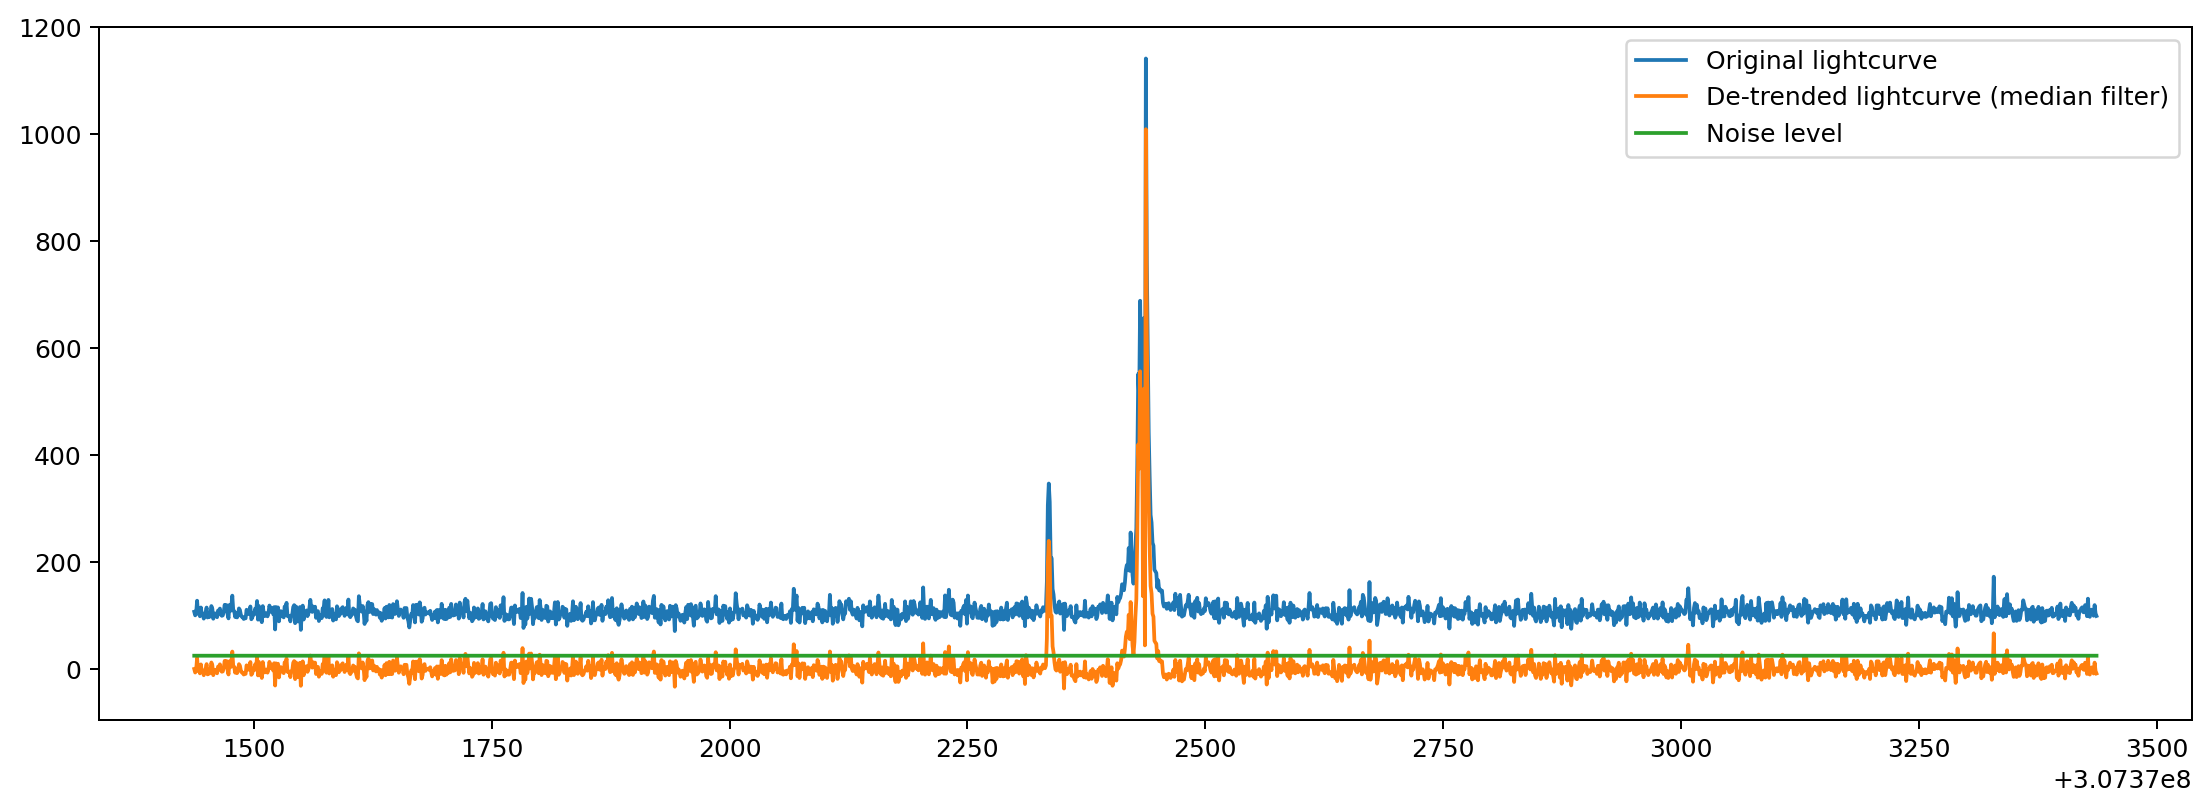

In [28]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc_times[0][max-1000:max+1000], lc_rates[0][max-1000:max+1000])
plt.plot(lc_times[0][max-1000:max+1000], lc_med_detrend[max-1000:max+1000])
plt.plot(lc_times[0][max-1000:max+1000], 24.84067*np.ones_like(lc_times[0])[max-1000:max+1000])
plt.legend(['Original lightcurve', 'De-trended lightcurve (median filter)', 'Noise level'])
plt.show()

In [29]:
noise_med = np.sqrt(np.average(lc_med_detrend**2))

In [30]:
noise_med

24.84067

In [31]:
peak_med = np.max(lc_med_detrend) - noise_med

In [32]:
snr_med = peak_med/noise_med
print(snr_med)

39.63566


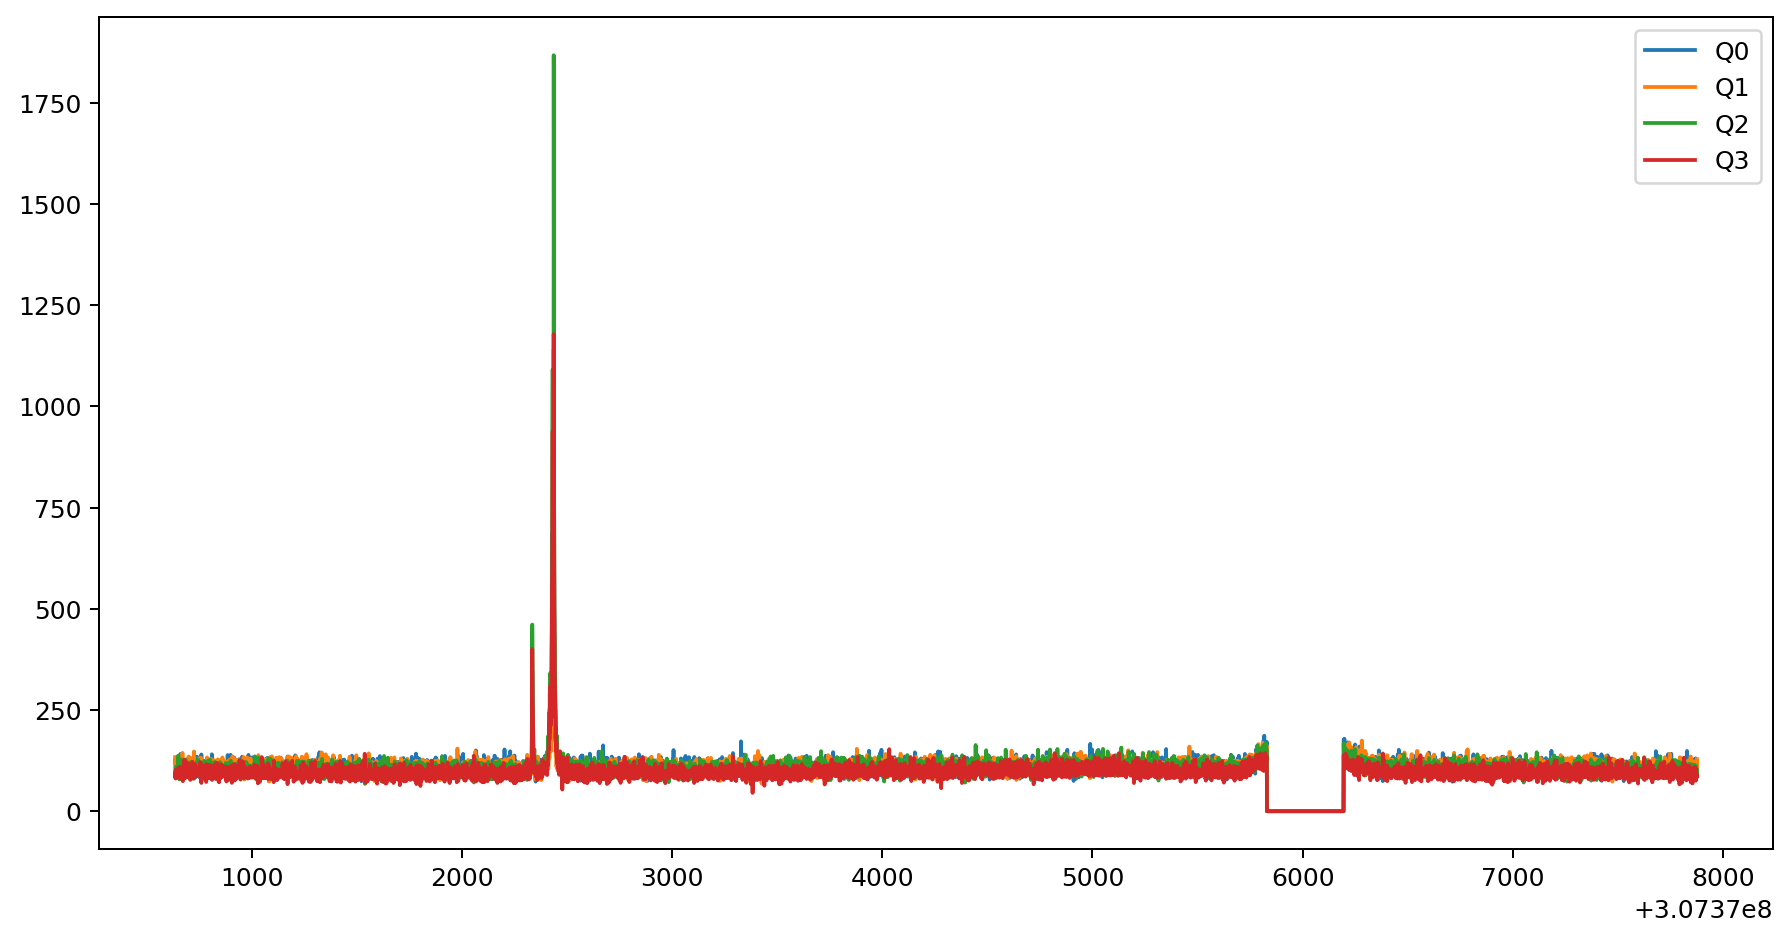

In [33]:
plt.figure(dpi=180, figsize=(12,6))
for i in range(0,4):
    plt.plot(clean_lc[i].field('TIME'), clean_lc[i].field('RATE'))
plt.legend(['Q0', 'Q1', 'Q2', 'Q3'])
plt.show()

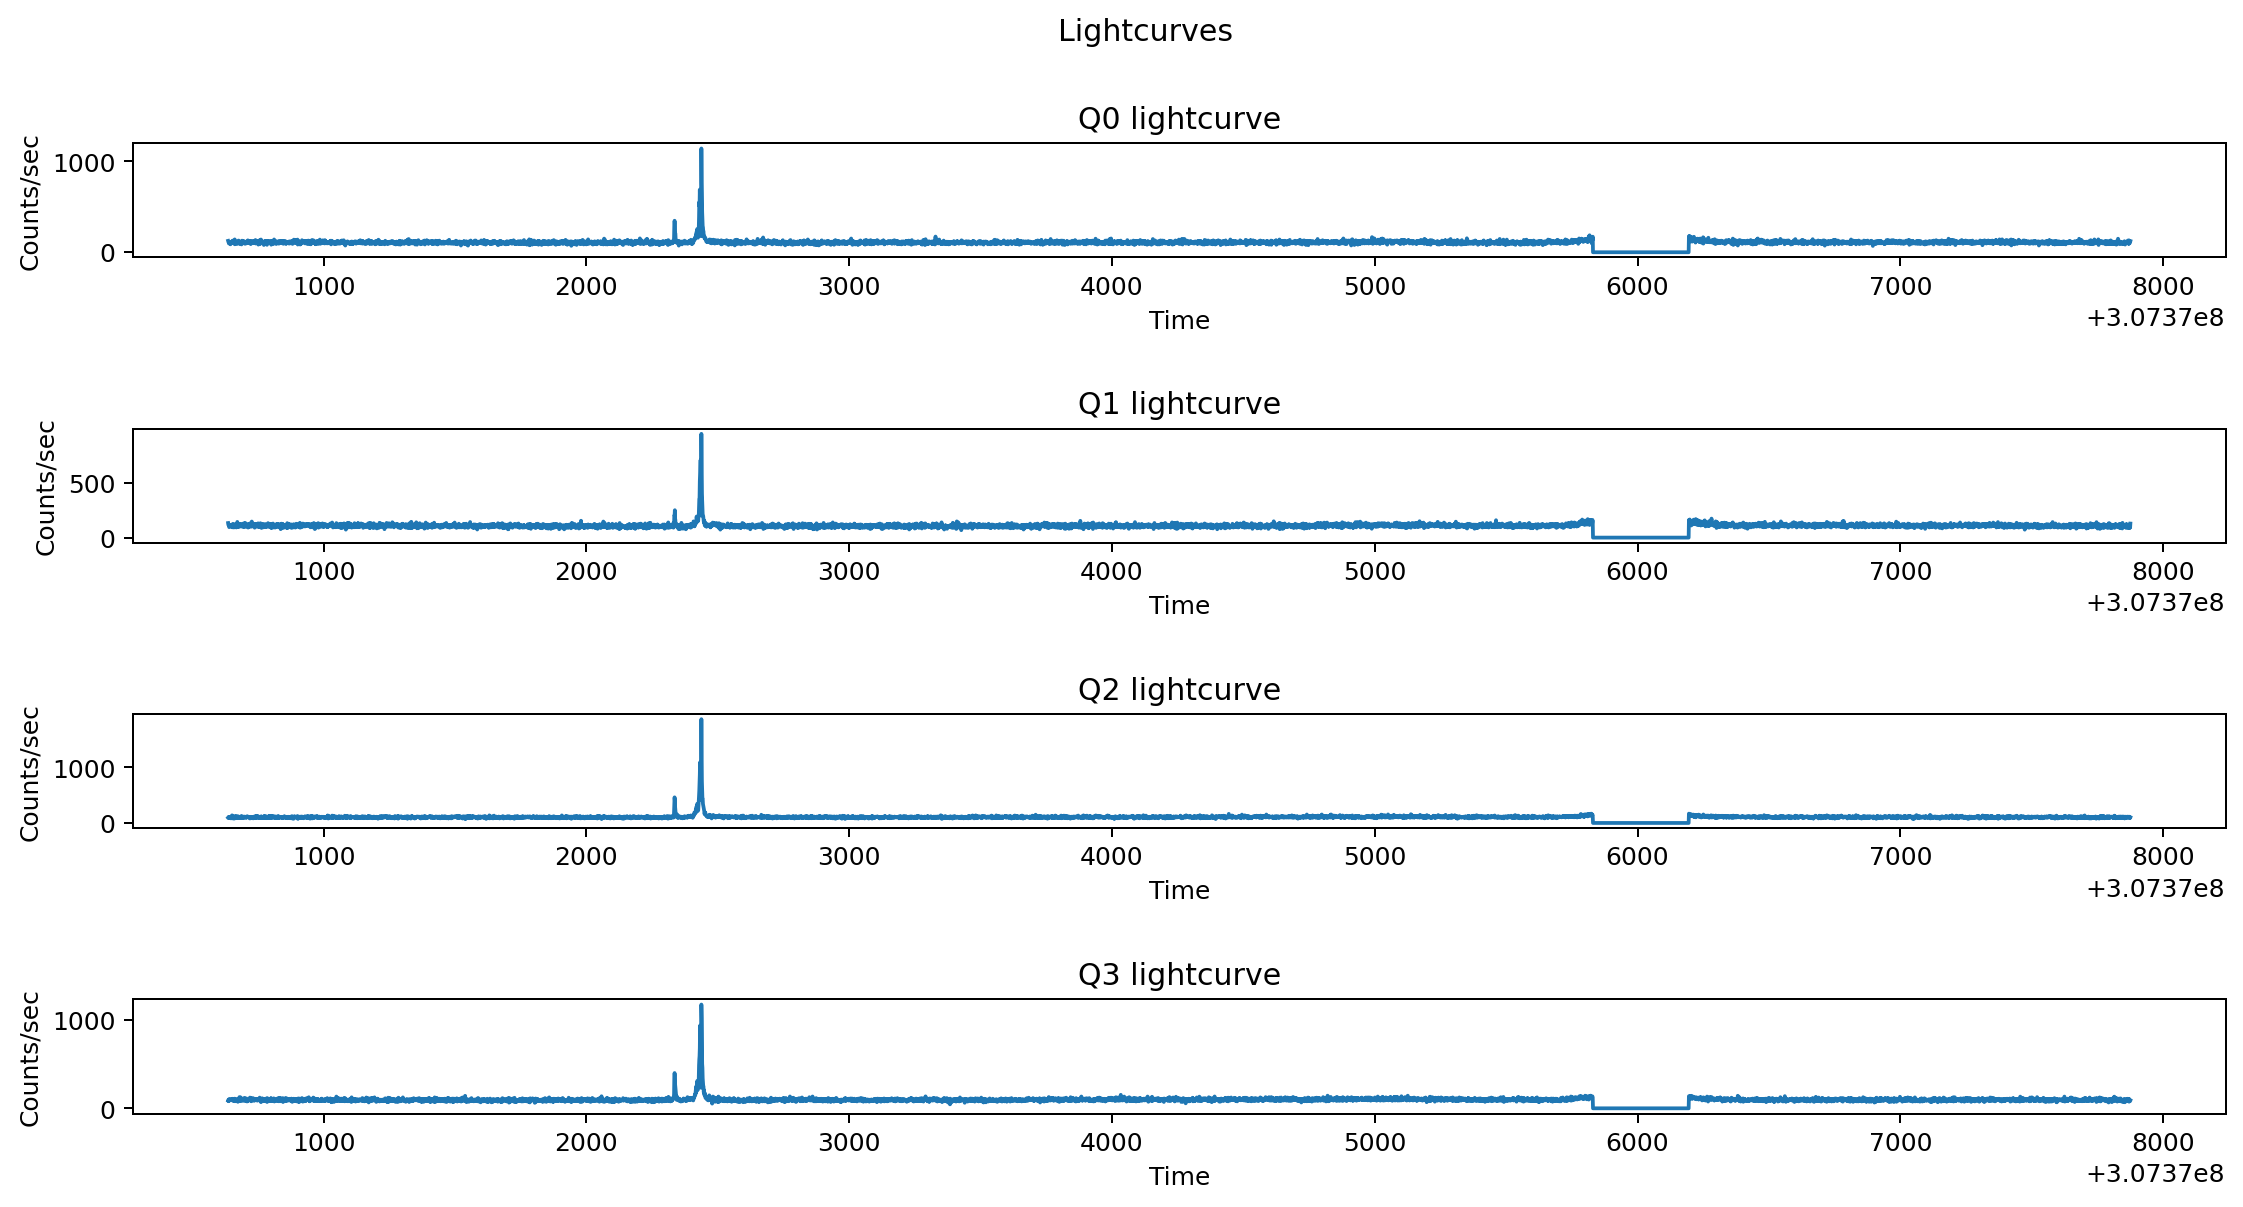

In [34]:

plt.figure(dpi=180, figsize=(15,7))
plt.suptitle('Lightcurves')
for i in range (0,4):
    plt.subplot(4,1,i+1)
    plt.subplots_adjust(hspace=1.5)
    plt.title('Q'+str(i)+ ' lightcurve')
    plt.xlabel('Time')
    plt.ylabel('Counts/sec')
    plt.plot(clean_lc[i].field('TIME'), clean_lc[i].field('RATE'))
  
    
plt.savefig('Lightcurves.png')

In [35]:
pha1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.pha')
pha2 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.pha')
pha3 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.pha')
pha4 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.pha')

In [36]:
specdata1 = pha1[1].data
specdata2 = pha2[1].data
specdata3 = pha3[1].data
specdata4 = pha4[1].data

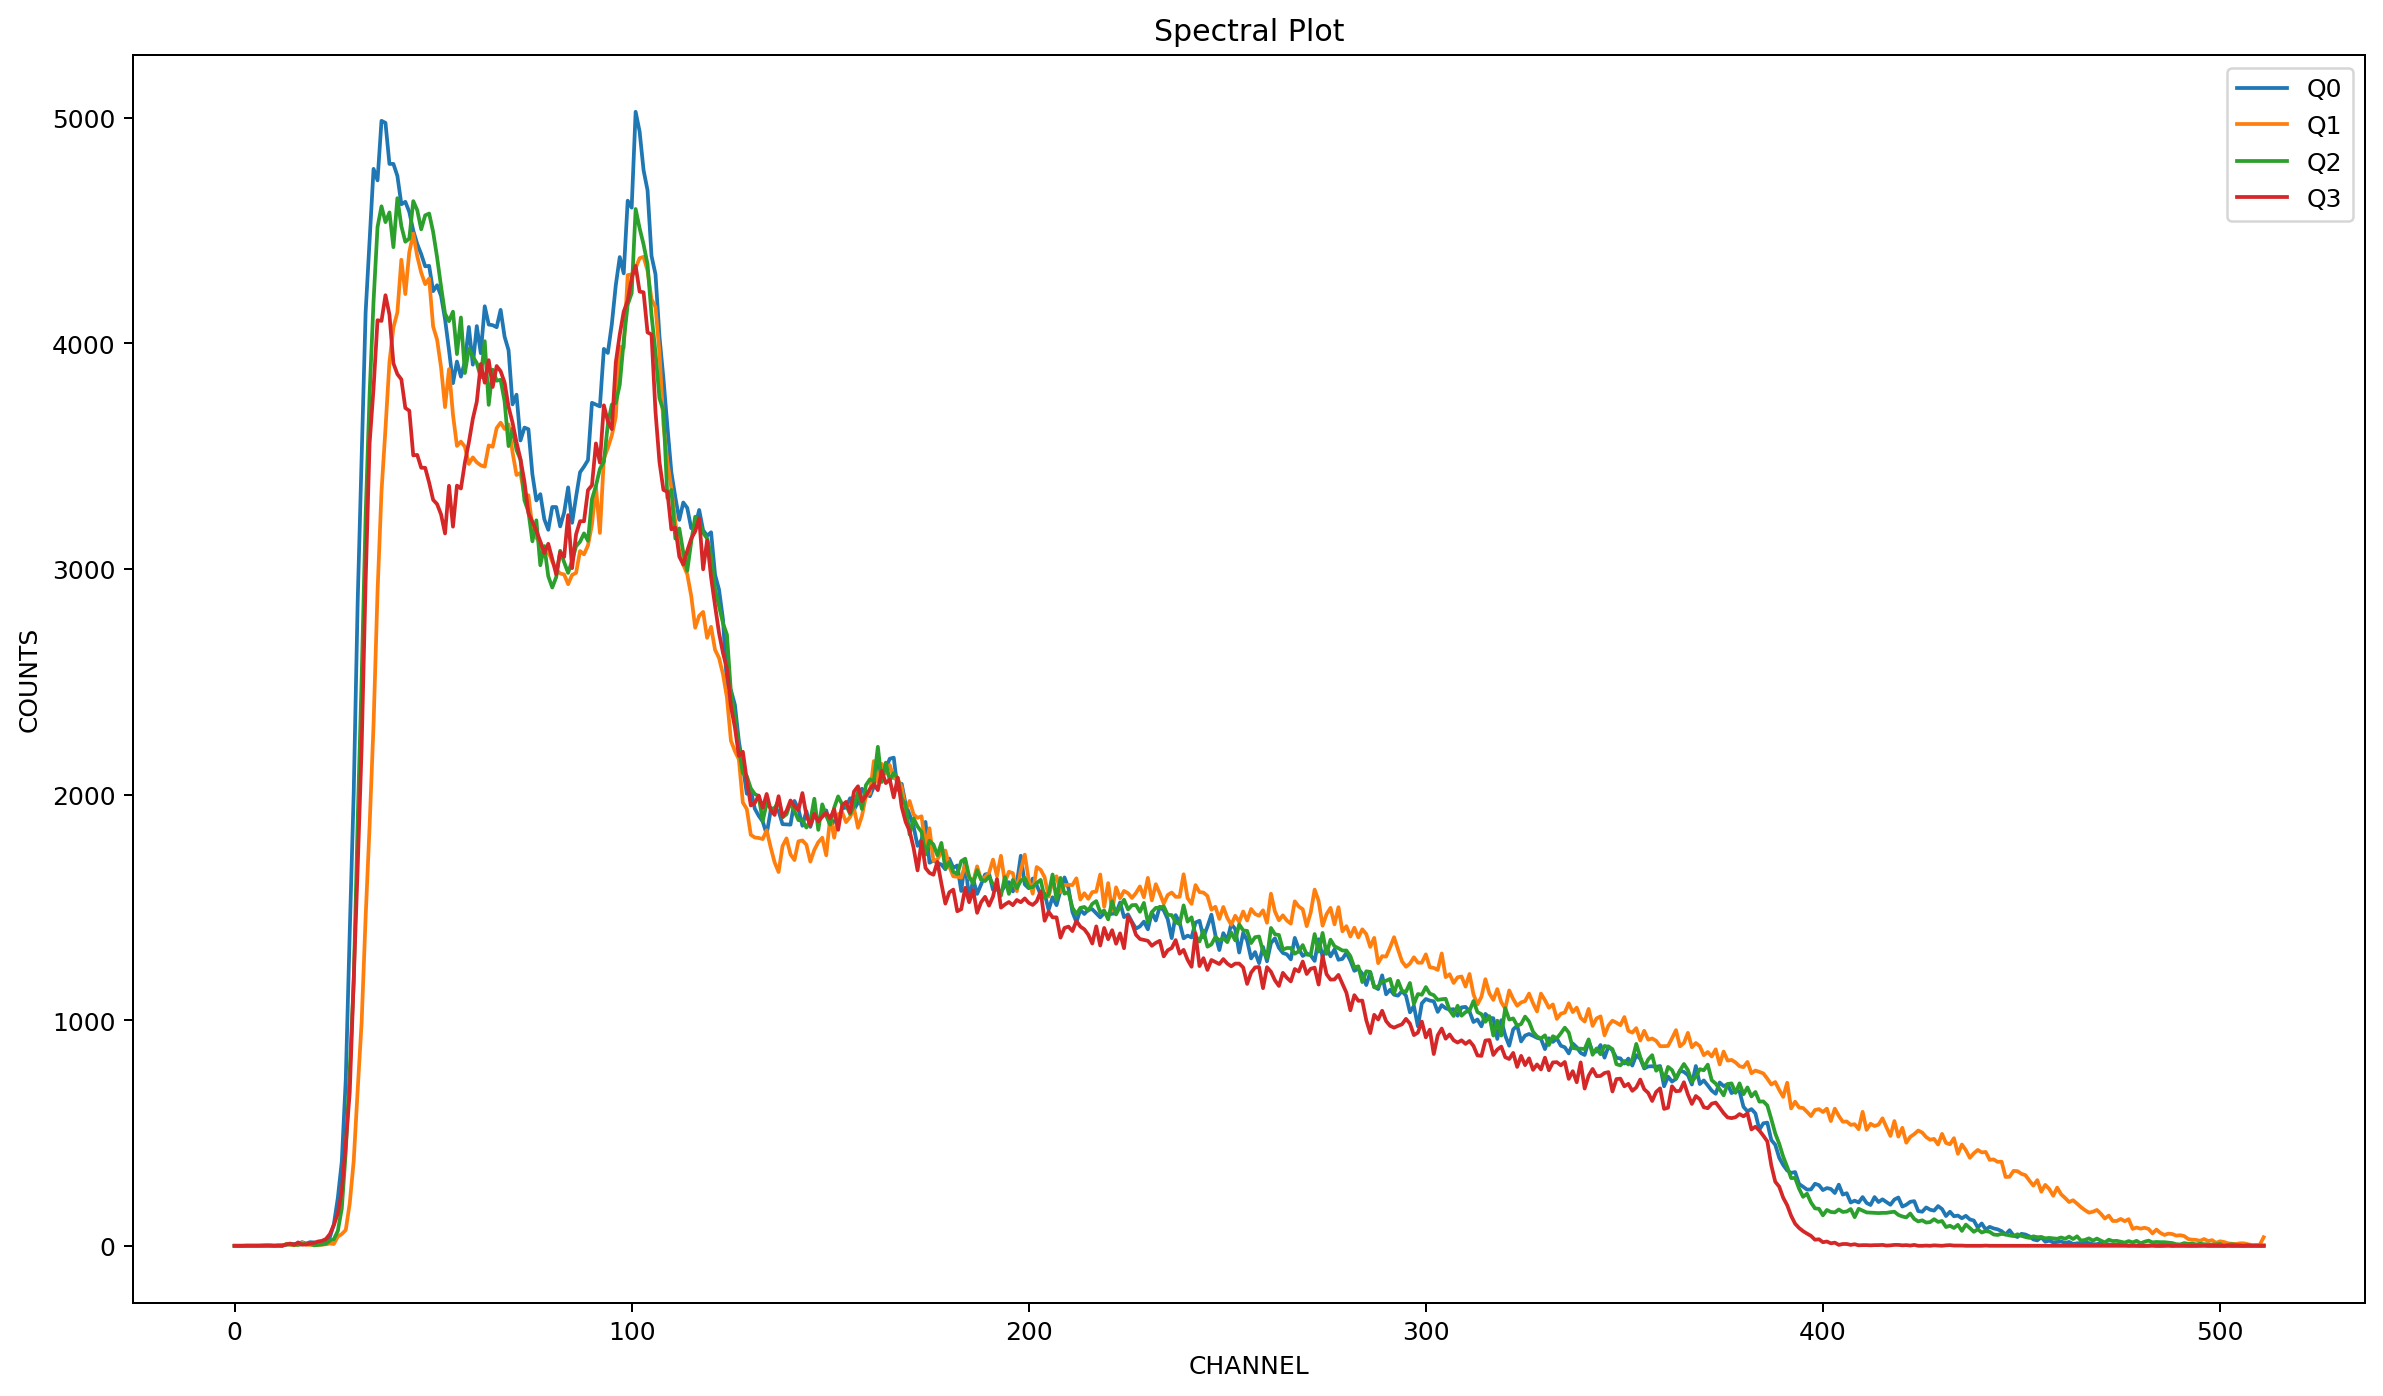

In [37]:
plt.figure(dpi=180, figsize=(16,9))
plt.title("Spectral Plot")
plt.plot(specdata1['CHANNEL'], specdata1['COUNTS'])
plt.plot(specdata2['CHANNEL'], specdata2['COUNTS'])
plt.plot(specdata3['CHANNEL'], specdata3['COUNTS'])
plt.plot(specdata4['CHANNEL'], specdata4['COUNTS'])
plt.xlabel('CHANNEL')
plt.ylabel('COUNTS')
plt.legend(['Q0','Q1','Q2', 'Q3'])
plt.savefig('Spectral Plot')

In [38]:
im1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.img_Q0')
im2 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.img_Q1')
im3 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.img_Q2')
im4 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.img_Q3')

In [39]:
im_data = [im1[1].data, im2[1].data, im3[1].data, im4[1].data]

In [40]:
dpi = fits.open('test.dpi')

FileNotFoundError: [Errno 2] No such file or directory: 'test.dpi'

In [ ]:
dpi.info()

Filename: test.dpi
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  Q0            1 ImageHDU        67   (64, 64)   float32   
  2  Q1            1 ImageHDU        67   (64, 64)   float32   
  3  Q2            1 ImageHDU        67   (64, 64)   float32   
  4  Q3            1 ImageHDU        67   (64, 64)   float32   
  5  FULL_DPI      1 ImageHDU        40   (128, 128)   float32   


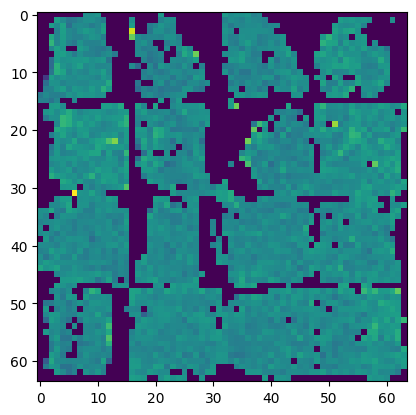

In [ ]:
plt.imshow(dpi[1].data)

In [ ]:
im1.info()

Filename: AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.img_Q0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  Q0            1 ImageHDU        70   (481, 481)   float32   


In [ ]:
np.size(im_data[0])

231361

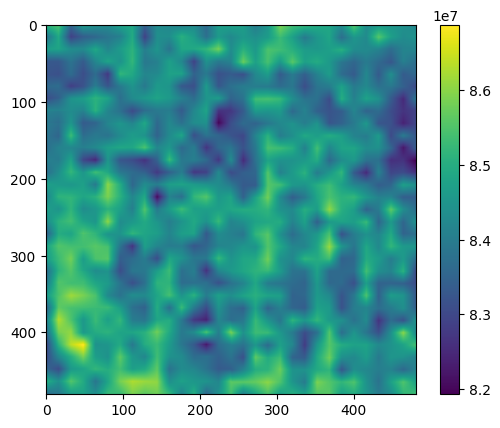

In [ ]:
plt.imshow(np.array(im_data[0]))
plt.colorbar()

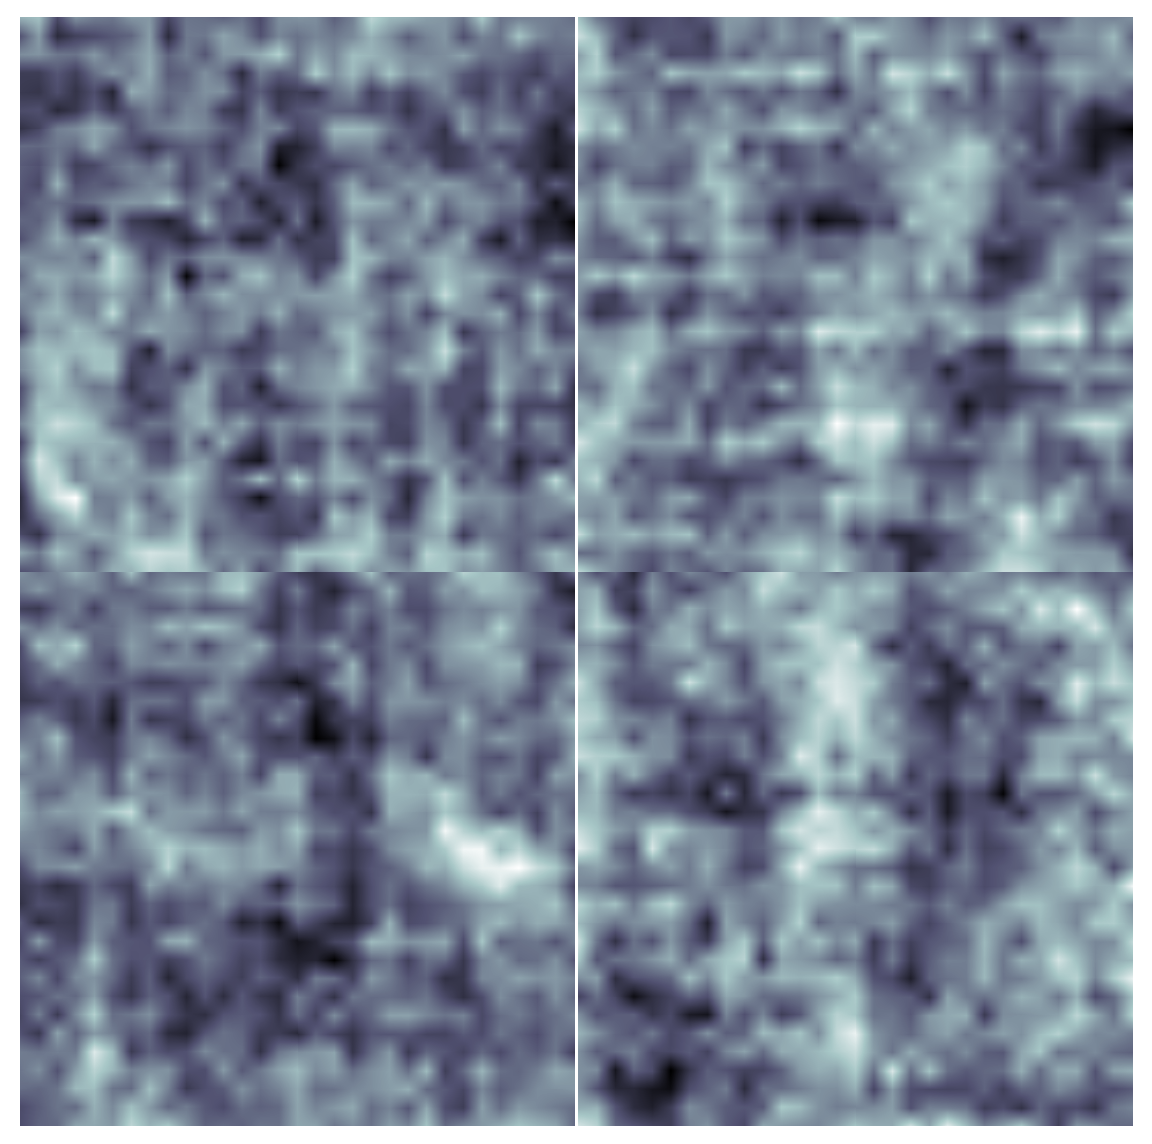

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=180)
for i in range(0,4):
    plt.axis('equal')
    plt.subplot(2,2,i+1)
    plt.imshow(im_data[i], cmap='bone')
    plt.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('image.png')

In [ ]:
evt = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_bc.evt')

In [ ]:
evt.info()

Filename: AS1A06_002T02_9000003206_21631cztM0_level2_bc.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      88   ()      
  1  Q0            1 BinTableHDU    122   1547835R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  2  Q1            1 BinTableHDU    122   1620032R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  3  Q2            1 BinTableHDU    122   1332730R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  4  Q3            1 BinTableHDU    122   2414593R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  5  VETOSPECTRUM    1 BinTableHDU     75   27513R x 4C   [D, D, 256I, B]   
  6  SSM Data      1 BinTableHDU     91   272R x 7C   [D, D, 256I, 512I, 512I, 512I, B]   
  7  TEMP          1 BinTableHDU     82   272R x 4C   [D, D, 16E, B]   
  8  GTI           1 BinTableHDU     79   351R x 2C   [1D, 1D]   
  9  Q0_GTI        1 BinTableHDU     79   154R x 2C   [1D, 1D]   
 10  Q1_GTI        1 BinTableHDU     79   154R x 2C   [1D, 

In [ ]:
evt[1].data

FITS_rec([(3.07370635e+08, 1.09128150e+08,    126,    717,  6, 165, 37, 37,      0, 0, 283, 146.55196 ),
          (3.07370635e+08, 1.09128150e+08,    127,    704,  6, 181, 37, 36,      0, 0, 275, 142.55217 ),
          (3.07370635e+08, 1.09128150e+08,    648,    131, 14,   4, 36, 15,      0, 0,  57,  33.795162),
          ...,
          (3.07377878e+08, 1.09135393e+08,  49130,     99,  9,  47, 31, 29,      0, 0,  46,  28.18828 ),
          (3.07377878e+08, 1.09135393e+08,  49131,    260,  9,  31, 31, 30,      0, 0, 118,  64.1294  ),
          (3.07377878e+08, 1.09135393e+08,  49231,    334, 15, 232, 56,  1,      0, 0, 120,  65.257484)],
         dtype=(numpy.record, [('Time', '>f8'), ('CZTSECCNT', '>f8'), ('CZTNTICK', '>i2'), ('PHA', '>i2'), ('DetID', 'u1'), ('pixID', 'u1'), ('DETX', 'u1'), ('DETY', 'u1'), ('veto', '>i2'), ('alpha', 'u1'), ('PI', '>i2'), ('ENERGY', '>f4')]))

In [ ]:
evt[1].data['DETX']

array([37, 37, 36, ..., 31, 31, 56], dtype=uint8)

In [ ]:
evt[1].data['DETY']

array([37, 36, 15, ..., 29, 30,  1], dtype=uint8)

In [ ]:
pha1.info()

Filename: AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SPECTRUM      1 BinTableHDU     74   512R x 3C   ['1J', '1E', '1E']   


In [ ]:
rsp1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.rsp')
rsp2 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.rsp')
rsp3 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.rsp')
rsp4 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.rsp')

In [ ]:
rsp1.info()

Filename: AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.rsp
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  EBOUNDS       1 BinTableHDU     29   512R x 3C   [I, E, E]   
  2  MATRIX        1 BinTableHDU     44   300R x 6C   [E, E, I, J, J, PE(512)]   


In [ ]:
rsp1_data = rsp1[2].data
rsp2_data = rsp2[2].data
rsp3_data = rsp3[2].data
rsp4_data = rsp4[2].data

In [ ]:
l1 = [np.array(rsp1_data['MATRIX'][i], dtype=float) for i in range(0,300)]
l1 = np.array(l1)
l2 = [np.array(rsp2_data['MATRIX'][i], dtype=float) for i in range(0,300)]
l2 = np.array(l2)
l3 = [np.array(rsp3_data['MATRIX'][i], dtype=float) for i in range(0,300)]
l3 = np.array(l3)
l4 = [np.array(rsp4_data['MATRIX'][i], dtype=float) for i in range(0,300)]
l4 = np.array(l4)

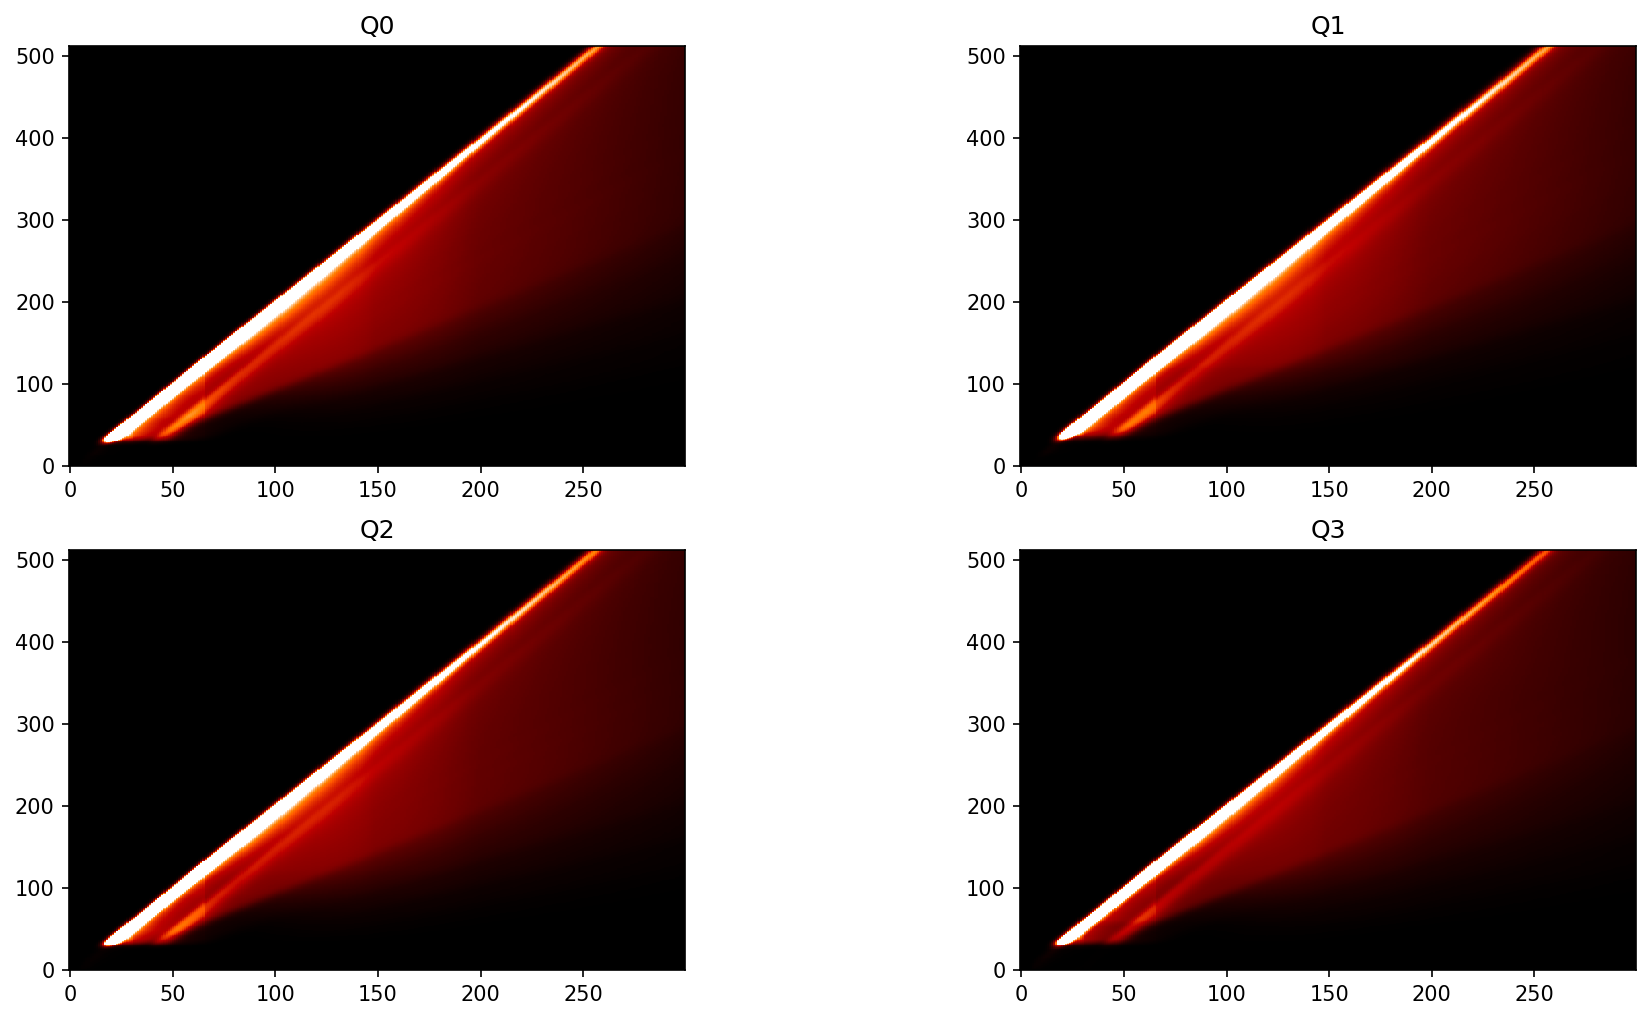

In [ ]:
plt.figure(dpi=150, figsize=(15,8))
plt.subplot(2,2,1)
plt.title('Q0')
plt.imshow(l1.T, cmap='gist_heat', interpolation='none', origin='lower', vmin=0, vmax=1, aspect=0.4)
plt.subplot(2,2,2)
plt.title('Q1')
plt.imshow(l2.T, interpolation='none', cmap='gist_heat', origin='lower', vmin=0, vmax=1, aspect=0.4)
plt.subplot(2,2,3)
plt.title('Q2')
plt.imshow(l3.T, interpolation='none', cmap='gist_heat', origin='lower', vmin=0, vmax=1, aspect=0.4)
plt.subplot(2,2,4)
plt.title('Q3')
plt.imshow(l4.T, interpolation='none', cmap='gist_heat', origin='lower', vmin=0, vmax=1, aspect=0.4)
plt.show()